<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-LDPCparam-files" data-toc-modified-id="Create-LDPCparam-files-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create LDPCparam files</a></span></li></ul></div>

<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/test_fec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [17]:
from optic.comm.modulation import modulateGray, demodulateGray, grayMapping
from optic.comm.metrics import signal_power, calcLLR, fastBERcalc
from optic.comm.fec import par2gen, encodeLDPC #ldpcDecode
from optic.models.channels import awgn
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import io
from scipy.sparse import csr_matrix, csc_matrix
from tqdm.notebook import tqdm
from numba import njit

import os.path as path

In [3]:
from commpy.channelcoding import ldpc
#from commpy.channelcoding.ldpc import triang_ldpc_systematic_encode as encodeLDPC
from commpy.channelcoding.ldpc import ldpc_bp_decode as decodeLDPC
from commpy.channelcoding.interleavers import RandInterlv

In [4]:
%load_ext autoreload
%autoreload 2

## Create LDPCparam files

In [20]:
pathdir = r'C:\Users\edson.DESKTOP-54IJM4F\Documents\GitHub\robochameleon-private\addons\AR4JA_LDPC_FEC'
#pathdir = r'C:\Users\edson\OneDrive\Documentos\GitHub\robochameleon-private\addons\IEEE_802_11n_LDPC_FEC'

d = sp.io.loadmat(pathdir+'\LDPC_AR4JA_1280b_R45.mat')
#d = sp.io.loadmat(pathdir+'\LDPC_11nD2_648b_R12.mat')
#d = sp.io.loadmat('LDPC_AR4JA_1280b_R45.mat')
H = csr_matrix(d['H'])

#H = d['LDPC']['H'] # parity check matrix
#H = H[0][0][0][0][0]
#H = sp.sparse.csr_matrix.todense(H).astype(np.int8)
#H = sp.sparse.csr_matrix(H)
#H = np.asarray(H)

# file_path = r'C:\Users\edson.DESKTOP-54IJM4F\Documents\GitHub\OptiCommPy-private\optic\fecParams\LDPC_ARJA_1280b_R45.txt'

# ldpc.write_ldpc_params(H, file_path)

In [22]:
# FEC parameters
family = "AR4JA"
R = 45
n = 1280

mainDir  = path.abspath(path.join("../"))
filename = '\LDPC_' + family + '_' + str(n) + 'b_R' + str(R) + '.txt'
filePath = mainDir + r'\optic\fecParams' + filename
filePath

'C:\\Users\\edson.DESKTOP-54IJM4F\\Documents\\GitHub\\OptiCommPy-private\\optic\\fecParams\\LDPC_AR4JA_1280b_R45.txt'

In [8]:
def BPDecoder(llr_array, H, MAX_ITER = 50):
    """
    LLR decoding of multiple codewords using belief propagation algorithm
    :param llr_array: 2D numpy array of LLR values of codewords
    :param H: Non-standard parity-check matrix
    :return: 2D numpy array of decoded LLR values
    """
    # Number of rows and columns of the parity-check matrix
    m, n = H.shape
    
    # Number of codewords
    num_codewords = llr_array.shape[0]
    
    # Initialize the messages passed between check and variable nodes
    check_to_var_msg = np.zeros((m, n))
    final_llr_array = np.zeros(llr_array.shape)
    
    for indCw in tqdm(range(num_codewords)):
        llr = llr_array[indCw, :]
        var_to_check_msg = llr.copy()
        # Iterate until the stopping criterion is met
        for indIter in range(MAX_ITER):
            # Update messages passed from variable to check nodes
            for j in range(n):
                indices = np.argwhere(H[:, j] == 1)[0]
                var_to_check_msg[j] = llr[j] + np.sum(check_to_var_msg[indices, j])
            
            # Update messages passed from check to variable nodes
            for i in range(m):
                indices = np.argwhere(H[i, :] == 1)[0]
                prod = np.prod(np.tanh(var_to_check_msg[indices]/2))
                check_to_var_msg[i, indices] = 2*np.arctanh(prod)
            
        # Compute the final LLRs
        final_llr = llr + np.sum(check_to_var_msg, axis=0)
        final_llr_array[indCw, :] = final_llr
        
    return final_llr_array


In [24]:
G, colSwaps, Hnew = par2gen(H)

revertColSwaps = np.argsort(colSwaps)

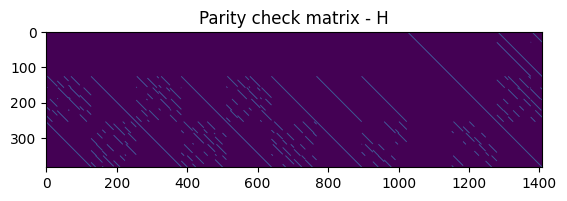

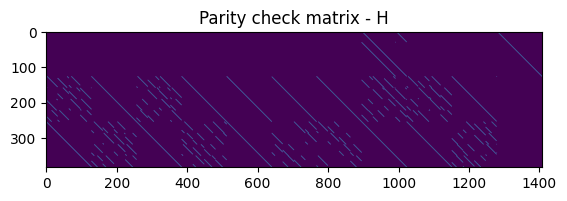

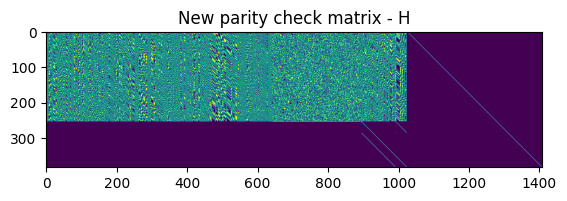

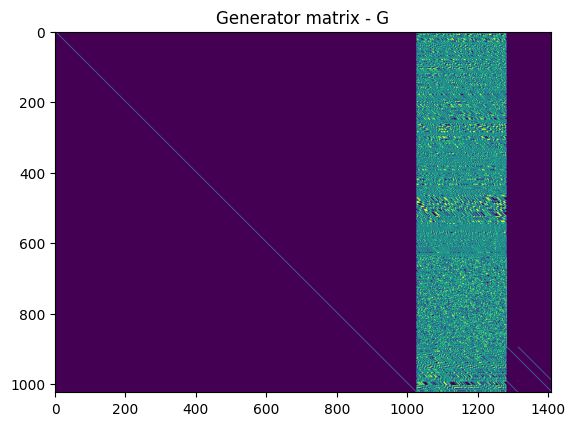

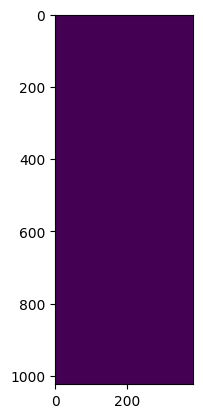

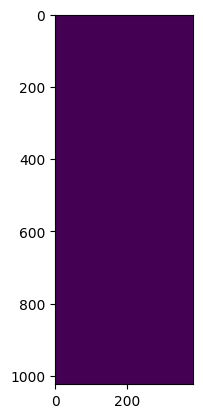

In [25]:
plt.imshow(csr_matrix.todense(H).astype(np.int8));
plt.title('Parity check matrix - H')
plt.figure()
plt.imshow(csr_matrix.todense(H[:,colSwaps]).astype(np.int8));
plt.title('Parity check matrix - H')
plt.figure()
plt.imshow(Hnew);
plt.title('New parity check matrix - H')
plt.figure()
plt.imshow(G);
plt.title('Generator matrix - G')
plt.figure()
plt.imshow(np.mod(G[:,revertColSwaps]@H.T, 2));
plt.figure()
plt.imshow(np.mod(G@Hnew.T, 2));

In [26]:
print('H :', H.shape)
print('G :', G.shape)
print('n = ', H.shape[1])
print('k = ', G.shape[0])
print('R = ', round(G.shape[0]/1280,2))

H : (384, 1408)
G : (1024, 1408)
n =  1408
k =  1024
R =  0.8


## Test LDPC encoder

In [27]:
Nwords = 10

# generate random bits
bits = np.random.randint(2, size = (G.shape[0], Nwords))

codedbits, colSwaps = encodeLDPC(H, bits)
np.mod(H[:,colSwaps]@codedbits, 2)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [44]:
# Run AWGN simulation 
EbN0dB = 15
M      = 64
Nwords = 6
nIter  = 10

# modulation parameters
constSymb = grayMapping(M,'qam')        # constellation
bitMap = demodulateGray(constSymb, M, 'qam') # bit mapping
bitMap = bitMap.reshape(-1, int(np.log2(M)))
Es = signal_power(constSymb)                 # mean symbol energy

# generate random bits
bits = np.random.randint(2, size = (G.shape[0], Nwords))

# encode data bits with LDPC soft-FEC
# bitsTx, codedBitsTx, interlv = ldpcEncode(bits, LDPCparams)
# codedBitsTx = ldpcEncode(bits, LDPCparams)
codedBits, colSwaps = encodeLDPC(H, bits)
#codedBitsTx = codedBits[0:1280,:]
codedBitsTx = codedBits.copy()
codedBitsTx = (codedBitsTx.T).reshape(1, -1).T

# Map bits to constellation symbols
symbTx = modulateGray(codedBitsTx, M, 'qam')

# Normalize symbols energy to 1
symbTx = symbTx/np.sqrt(signal_power(symbTx))

# AWGN    
snrdB  = EbN0dB + 10*np.log10(np.log2(M))
symbRx = awgn(symbTx, snrdB)

# pre-FEC BER calculation (hard demodulation)
BER, _, _ = fastBERcalc(symbRx, symbTx, M, 'qam')
print('BER = %.2e'%BER[0])

# soft-demodulation
noiseVar = 1/10**(snrdB/10)
px = np.ones(M)/M
llr = calcLLR(symbRx, noiseVar, constSymb/np.sqrt(Es), bitMap, px)

llr_dec = BPDecoder(llr.reshape(codedBits.shape[1],-1), H, MAX_ITER = 50)
llr_dec
# soft-FEC decoding
#_, decodedBits_hd, llr_out = ldpcDecode(llr, revertColSwaps, LDPCparams, nIter, alg="SPA")
#decodedBits, llr_out = ldpcDecode(llr, interlv, LDPCparams, nIter, alg="SPA")

# N = LDPCparams["n_vnodes"]   
# n = 1280        
# dep = int(N-n)

# # reshape received LLRs
# llr_array = llr.reshape(-1, n)    

# # depuncturing
# if dep > 0:
#     llr_array = np.concatenate((llr_array, np.zeros((llr_array.shape[0], dep))), axis=1)

# llr_array = llr_array[:, revertColSwaps]
    
# llr_out = BPDecoder(llr_array, H)

# print(llr_out.shape)

BER = 3.55e-04


  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\edson.DESKTOP-54IJM4F\AppData\Local\Temp\ipykernel_14956\3322397287.py:241: RuntimeWarning: divide by zero encountered in arctanh
  check_to_var_msg[i, indices] = 2*np.arctanh(prod)


array([[          nan,          -inf,           inf, ...,  -21.44807641,
         -14.69224013,  -71.71341699],
       [          nan,          -inf,           inf, ...,   15.33238813,
        -162.43028584,   18.0031125 ],
       [          nan,          -inf,           inf, ...,  171.65448228,
          21.07784483,  -15.06247157],
       [          nan,          -inf,           inf, ...,  -77.25242142,
          20.55605274,  309.91250322],
       [          nan,          -inf,           inf, ...,   22.43942566,
          -9.99385764,  -88.43327876],
       [          nan,          -inf,           inf, ...,  304.94354629,
          80.19114091,   22.0254124 ]])

In [63]:
llrs = llr_out[colSwaps,:]
decodedBits = (-np.sign(llrs)+1)//2

# post-FEC BER calculation
BERpre = np.mean(np.logical_xor(bits, decodedBits_hd[0:K,:]))
BERpost = np.mean(np.logical_xor(bits, decodedBits[0:K,:]))

print('BERpreFEC = %.2e'%BERpre)
print('BERpostFEC = %.2e'%BERpost)
print('Number of bits = ', decodedBits.size)

BERpreFEC = 2.28e-03
BERpostFEC = 5.17e-01
Number of bits =  4224


C:\Users\edson\AppData\Local\Temp\ipykernel_21108\2374432740.py:2: RuntimeWarning: invalid value encountered in floor_divide
  decodedBits = (-np.sign(llrs)+1)//2


In [41]:
llr.reshape(codedBits.shape).shape

(1408, 60)

In [131]:
decodedBits.shape

(1408, 60)

In [ ]:
Nwords = 10
nIter  = 50

# FEC parameters
LDPCparams = ldpc.get_ldpc_code_params(filePath)
LDPCparams['filename'] = filename
K = LDPCparams['n_vnodes'] - LDPCparams['n_cnodes']

# Run BER vs Ebn0 Monte Carlo simulation 
qamOrder  = [64]  # Modulation order
EbN0dB_  = np.arange(7, 9.5, 0.05)

BERpre   = np.zeros((len(EbN0dB_),len(qamOrder)))
BERpost  = np.zeros((len(EbN0dB_),len(qamOrder)))

BERpre[:]  = np.nan
BERpost[:] = np.nan

for ii, M in enumerate(qamOrder):
    print('run sim: M = ', M)

    # modulation parameters
    constSymb = GrayMapping(M,'qam')        # constellation
    bitMap = demodulateGray(constSymb, M, 'qam') # bit mapping
    bitMap = bitMap.reshape(-1, int(np.log2(M)))
    Es = signal_power(constSymb) # mean symbol energy

    for indSNR in tqdm(range(EbN0dB_.size)):

        EbN0dB = EbN0dB_[indSNR]

        # generate random bits
        bits = np.random.randint(2, size = (K, Nwords))

        # encode data bits with LDPC soft-FEC
        bitsTx, codedBitsTx, interlv = ldpcEncode(bits, LDPCparams)

        # Map bits to constellation symbols
        symbTx = modulateGray(bitsTx, M, 'qam')

        # Normalize symbols energy to 1
        symbTx = symbTx/np.sqrt(signal_power(symbTx))

        # AWGN    
        snrdB = EbN0dB + 10*np.log10(np.log2(M))
        symbRx = awgn(symbTx, snrdB)

        # pre-FEC BER calculation (hard demodulation)
        BERpre[indSNR, ii], _, _ = fastBERcalc(symbRx, symbTx, M, 'qam')
        #print('BER = %.2e'%BERpre[indSNR, ii])

        # soft-demodulation
        noiseVar = 1/10**(snrdB/10)
        llr = calcLLR(symbRx, noiseVar, constSymb/np.sqrt(Es), bitMap)

        # soft-FEC decoding
        decodedBits, llr_out = ldpcDecode(llr, interlv, LDPCparams, nIter, alg="SPA")

        # post-FEC BER calculation
        BERpost[indSNR, ii] = np.mean(np.logical_xor(codedBitsTx, decodedBits))
        #print('BERpostFEC = %.2e'%BERpost[indSNR, ii])

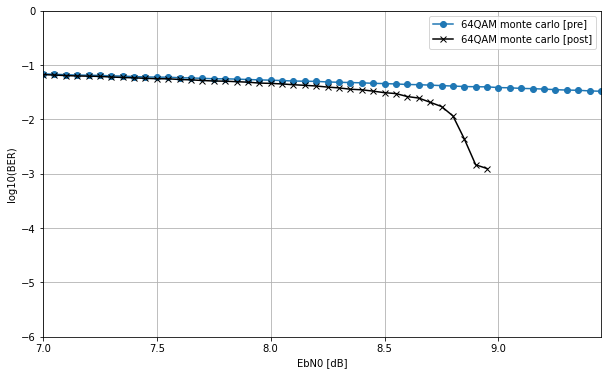

In [9]:
# Plot simulation results       
BERpre[BERpre==0] = np.nan
BERpost[BERpost==0] = np.nan

plt.figure(figsize=(10,6))
for ii, M in enumerate(qamOrder):
    plt.plot(
        EbN0dB_,
        np.log10(BERpre[:, ii]),
        'o-',
        label=f'{str(M)}QAM monte carlo [pre]',
    )


#plt.gca().set_prop_cycle(None)

for ii, M in enumerate(qamOrder):
    plt.plot(
        EbN0dB_,
        np.log10(BERpost[:, ii]),
        'kx-',
        label=f'{str(M)}QAM monte carlo [post]',
    )


plt.xlim(min(EbN0dB_), max(EbN0dB_))
plt.ylim(-6, 0)
plt.legend();
plt.xlabel('EbN0 [dB]');
plt.ylabel('log10(BER)');
plt.grid()

In [70]:
import scipy as sp

def binaryproduct(X, Y):
    """Compute a matrix-matrix / vector product in Z/2Z."""
    A = X.dot(Y)
    
    try:
          A = A.toarray()
    except AttributeError:
          pass
    return A % 2

def gaussjordan(X, change=0):
    """Compute the binary row reduced echelon form of X.
    Parameters
    ----------
    X: array (m, n)
    change : boolean (default, False). If True returns the inverse transform
    Returns
    -------
    if `change` == 'True':
        A: array (m, n). row reduced form of X.
        P: tranformations applied to the identity
    else:
        A: array (m, n). row reduced form of X.
    """    
    A = np.copy(X)    
    m, n = A.shape

    if change:
        P = np.identity(m).astype(int)

    pivot_old = -1
    
    for j in range(n):
        filtre_down = A[pivot_old+1:m, j]
        pivot = np.argmax(filtre_down)+pivot_old+1

        if A[pivot, j]:
            pivot_old += 1
            if pivot_old != pivot:
                aux = np.copy(A[pivot, :])
                A[pivot, :] = A[pivot_old, :]
                A[pivot_old, :] = aux

            if change:
                aux = np.copy(P[pivot, :])
                P[pivot, :] = P[pivot_old, :]
                P[pivot_old, :] = aux

            for i in range(m):
                  if i != pivot_old and A[i, j]:
                        if change:
                            P[i, :] = abs(P[i, :]-P[pivot_old, :])
                        A[i, :] = abs(A[i, :]-A[pivot_old, :])

        if pivot_old == m-1:
            break

    if change:
        return A, P
    else:
        return A


def HtotG(H,sparse=True):
    """Return the generating coding matrix G given the LDPC matrix H.
    Parameters
    ----------
    H: array (n_equations, n_code). Parity check matrix of an LDPC code with
        code length `n_code` and `n_equations` number of equations.
    sparse: (boolean, default True): if `True`, scipy.sparse format is used
        to speed up computation.
    Returns
    -------
    G.T: array (n_bits, n_code). Transposed coding matrix.
    """     
    if type(H) == sp.sparse.csr.csr_matrix:
        H = H.toarray()       
   
    n_equations, n_code = H.shape
   
    # DOUBLE GAUSS-JORDAN:
    Href_col, tQ = gaussjordan(H.T, 1)
    Href_diag = gaussjordan(np.transpose(Href_col))   

    Q = tQ.T

    n_bits = int(n_code - Href_diag.sum())

    Y = np.zeros(shape=(n_code, n_bits)).astype(int)
    Y[n_code - n_bits:, :] = np.identity(n_bits)

    if sparse:
        Q = sp.sparse.csr_matrix(Q)
        Y = sp.sparse.csr_matrix(Y)

    tG = binaryproduct(Q, Y)

    return tG

In [59]:
x = np.array([[1, 2, 3], [4, 5, 6]])

In [60]:
x.reshape(-1,2)

array([[1, 2],
       [3, 4],
       [5, 6]])

In [61]:
x.ravel()

array([1, 2, 3, 4, 5, 6])